In [1]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random
from types import ModuleType
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
c = ModuleType("contstants")
# ------------------------------------- Constants -------------------------------------
c.Training_Data = 0
c.Model = 1
c.Client_Accuracies = 2
c.Client_Performance_Scores = 3
c.Current_Performance_Score = 4
c.Client_Age = 5
c.Optimizer = 6

"""
+---------------------------------------------------------------------------------+
|    ____ ___ _____ _    ____       _  ___    ____        _                 _     |
|   / ___|_ _|  ___/ \  |  _ \     / |/ _ \  |  _ \  __ _| |_ __ _ ___  ___| |_   |
|  | |    | || |_ / _ \ | |_) |____| | | | | | | | |/ _` | __/ _` / __|/ _ \ __|  |
|  | |___ | ||  _/ ___ \|  _ <_____| | |_| | | |_| | (_| | || (_| \__ \  __/ |_   |
|   \____|___|_|/_/   \_\_| \_\    |_|\___/  |____/ \__,_|\__\__,_|___/\___|\__|  |
+---------------------------------------------------------------------------------+
----------------------------------------------------------------------------------
+-----------------------+
|   _____ ___________   |
|  |_   _|_   _|  _  \  |
|    | |   | | | | | |  |
|    | |   | | | | | |  |
|   _| |_ _| |_| |/ /   |
|   \___/ \___/|___/    |
+-----------------------+

"""
def convert(set):
    return [*set,]

def iid_distribution_CIFAR(NUM_CLIENTS, trainset):
    # Define the transform to apply to the dataset
    client_map = dict()
    global_model = CIFAR10_CNN().to(device)
    models = [CIFAR10_CNN().to(device) for _ in range(NUM_CLIENTS)]

    for model in models:
        model.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(model.parameters(), lr=0.215) for model in models]

    clients_with_data = cifar_iid(trainset, NUM_CLIENTS)
    # Create a list to store the data loaders
    train_data_loaders = []

    for i in range(NUM_CLIENTS):
        cli_train = clients_with_data[i]
        train_data_loaders.append(cli_train)

    for client in range(NUM_CLIENTS):
        random_score = random.random()
        client_map.update({client: [train_data_loaders[client].astype(int), models[client], [], [random_score], random_score, 0, opt[client]]})
    
    return client_map, global_model

def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    
    for i in range(num_users):
        dict_users[i] = np.array(convert(dict_users[i]))

    return dict_users

""""
+---------------------------------------------------------------------+
|   __  __ _   _ ___ ____ _____   ____        _                 _     |
|  |  \/  | \ | |_ _/ ___|_   _| |  _ \  __ _| |_ __ _ ___  ___| |_   |
|  | |\/| |  \| || |\___ \ | |   | | | |/ _` | __/ _` / __|/ _ \ __|  |
|  | |  | | |\  || | ___) || |   | |_| | (_| | || (_| \__ \  __/ |_   |
|  |_|  |_|_| \_|___|____/ |_|   |____/ \__,_|\__\__,_|___/\___|\__|  |
+---------------------------------------------------------------------+

+-----------------------+
|   _____ ___________   |
|  |_   _|_   _|  _  \  |
|    | |   | | | | | |  |
|    | |   | | | | | |  |
|   _| |_ _| |_| |/ /   |
|   \___/ \___/|___/    |
+-----------------------+
"""


def iid_distribution_MNIST(NUM_CLIENTS, trainset):
    # Define the transform to apply to the dataset
    client_map = dict()
    clients_with_data = mnist_iid(trainset, NUM_CLIENTS)
    global_model = MNIST_MLP().to(device)
    models = [MNIST_MLP().to(device) for _ in range(NUM_CLIENTS)]
    for model in models:
        model.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(model.parameters(), lr=0.15) for model in models]
    # Create a list to store the data loaders
    train_data_loaders = []

    for i in range(NUM_CLIENTS):
        cli_train = clients_with_data[i]
        train_data_loaders.append(cli_train)

    for i in range(NUM_CLIENTS):
        random_score = random.random()
        client_map.update({i: [train_data_loaders[i].astype(int), models[i], [], [random_score], random_score, 0, opt[i]]})
    
    return client_map, global_model

def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    
    for i in range(num_users):
        dict_users[i] = np.array(convert(dict_users[i]))
    
    return dict_users

"""
+---------------------------------------------+
|   _   _                 _____ ___________   |
|  | \ | |               |_   _|_   _|  _  \  |
|  |  \| | ___  _ __ ______| |   | | | | | |  |
|  | . ` |/ _ \| '_ \______| |   | | | | | |  |
|  | |\  | (_) | | | |    _| |_ _| |_| |/ /   |
|  \_| \_/\___/|_| |_|    \___/ \___/|___/    |
+---------------------------------------------+
"""
def non_iid_distribution_MNIST(NUM_CLIENTS, trainset):
    # Define the classes to include in each data loader
    client_map = dict()
    global_model = MNIST_MLP().to(device)
    models = [MNIST_MLP().to(device) for _ in range(NUM_CLIENTS)]

    for model in models:
        model.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(model.parameters(), lr=0.15) for model in models]
    # Create a list to store the data loaders
    train_data_loaders = []
    # Load the MNIST dataset
    clients_with_shards = mnist_noniid(trainset, NUM_CLIENTS, 2)
    # Create a list to store the data loaders
    train_data_loaders = []

    for i in range(NUM_CLIENTS):
        cli_train= clients_with_shards[i]
        train_data_loaders.append(cli_train)
 
    
    for client in range(NUM_CLIENTS):
        random_score = random.random()
        client_map.update({client: [train_data_loaders[client].astype(int), models[client], [], [random_score], random_score, 0, opt[client]]})
    
    return client_map, global_model

def mnist_noniid(dataset, num_users, shards_per_cli):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    num_shards = num_users * shards_per_cli
    num_imgs = int(len(dataset) / num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.targets.numpy()
    
    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

"""
+---------------------------------------------------------------------------+
|   _   _                      _   _   _      _                      _      |
|  | \ | |                    | | | \ | |    | |                    | |     |
|  |  \| | ___ _   _ _ __ __ _| | |  \| | ___| |___      _____  _ __| | __  |
|  | . ` |/ _ \ | | | '__/ _` | | | . ` |/ _ \ __\ \ /\ / / _ \| '__| |/ /  |
|  | |\  |  __/ |_| | | | (_| | | | |\  |  __/ |_ \ V  V / (_) | |  |   <   |
|  \_| \_/\___|\__,_|_|  \__,_|_| \_| \_/\___|\__| \_/\_/ \___/|_|  |_|\_\  |
+---------------------------------------------------------------------------+
"""
# ------------------------------------- MLP MNIST -------------------------------------
class MNIST_MLP(nn.Module):
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# ------------------------------------- CNN CIFAR-10 -------------------------------------
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [2]:
def initialize_clients(NUM_CLIENTS, dataset, distribution, trainset):
    if dataset == 'MNIST':
        if distribution == 'iid':
            client_map = iid_distribution_MNIST(NUM_CLIENTS, trainset)
        else:
            client_map = non_iid_distribution_MNIST(NUM_CLIENTS, trainset)
    else:
        if distribution == 'iid':
            client_map = iid_distribution_CIFAR(NUM_CLIENTS, trainset)
    
    return client_map

In [3]:
def update_performance(client_map, selected_clients, threshold):
    for client in client_map.keys():
        if client in selected_clients:
            client_accuracies = client_map[client][c.Client_Accuracies]
            mean_acc = sum(client_accuracies) / len(client_accuracies)
            varience = sum([((x - mean_acc) ** 2) for x in client_accuracies]) / (len(client_accuracies))
            if varience > threshold:
                updated_score = client_map[client][c.Current_Performance_Score] + 1.0    
            else:
                updated_score = client_map[client][c.Current_Performance_Score]
        else:
                updated_score = client_map[client][c.Current_Performance_Score] 
        mean_performance_score = (sum(client_map[client][c.Client_Performance_Scores])+updated_score) / len(client_map[client][c.Client_Performance_Scores])
        client_map[client][c.Current_Performance_Score] = mean_performance_score

In [4]:
def update_age(client_map, selected_clients):
    for client in client_map.keys():
        if client in selected_clients:
            client_map[client][c.Client_Age] = 0
        else:
            client_map[client][c.Client_Age] = client_map[client][c.Client_Age]**2 + 1      

In [5]:
def train_and_test_client(client_map, selected_clients, local_epochs, trainset, test_loader, global_model, performance_threshold):
    for client in selected_clients:
        client_map[client][c.Model].load_state_dict(global_model.state_dict())
        model = client_map[client][c.Model]
        model.train()
        train_loader_ind = client_map[client][c.Training_Data]
        train_loader = DataLoader(trainset, batch_size=50,  num_workers=0, sampler=train_loader_ind)
        criterion = nn.CrossEntropyLoss()
        optimizer = client_map[client][c.Optimizer]
        for epoch in range(local_epochs):
            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        model.eval()
        correct = 0
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
        accuracy = correct / (len(test_loader.dataset))
        client_map[client][c.Client_Accuracies].append(accuracy)
    
    update_performance(client_map, selected_clients, performance_threshold)
    update_age(client_map, selected_clients)

In [6]:
def test_global_model(global_model, test_loader):
    global_model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = global_model(data)
            test_loss += F.cross_entropy(outputs, targets, reduction='sum').item() #sum up the batch loss
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / (len(test_loader.dataset))
    return accuracy, test_loss

In [7]:
def global_update(client_map, global_model):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_map[client][c.Model].state_dict()[k] for client in client_map.keys()], 0).mean(0)
    
    global_model.load_state_dict(global_dict)

    for client in client_map.keys():
        client_map[client][c.Model].load_state_dict(global_model.state_dict())

In [8]:
def prepend_list(lst, value):
    lst.insert(0, value)
    return lst

In [9]:
def AoU_or_Data_Shapley(client_map, age_threshold, select_per_round):
    selected_clients = []
    client_position = []
    highest_score = client_map[0][c.Current_Performance_Score]
    for client in client_map.keys():
        client_score = client_map[client][c.Current_Performance_Score]
        if client_score >= highest_score:
            highest_score = client_score

    for client in client_map.keys():
        if client_map[client][c.Current_Performance_Score] >= highest_score or client_map[client][c.Client_Age] > age_threshold:
            client_position = prepend_list(client_position, client)
        else:
            client_position.append(client)

    for i in range(select_per_round):
        selected_clients.append(client_position[i])
              
    return selected_clients

In [10]:
def AoU_AND_Data_Shapley(client_map, age_threshold, select_per_round):
    selected_clients = []
    client_position = []
    highest_score = client_map[0][c.Current_Performance_Score]
    for client in client_map.keys():
        client_score = client_map[client][c.Current_Performance_Score]
        if client_score >= highest_score:
            highest_score = client_score
    
    for client in client_map.keys():
            if client_map[client][c.Current_Performance_Score] >= highest_score and client_map[client][c.Client_Age] > age_threshold:
                client_position = prepend_list(client_position, client)
            else:
                client_position.append(client)

    for i in range(select_per_round):
        selected_clients.append(client_position[i])

    return selected_clients

In [11]:
def AoU_Only(client_map, age_threshold, select_per_round):
    selected_clients = []
    client_position = []
    for client in client_map.keys():
        if client_map[client][c.Client_Age] > age_threshold:
            client_position = prepend_list(client_position, client)
        else:
            client_position.append(client)
    
    for i in range(select_per_round):
        selected_clients.append(client_position[i])

    return selected_clients

In [12]:
def federated_learning_AND(client_map, global_model,train_loader,test_loader, age_threshold, select_per_round, rounds, local_epochs, performance_threshold):
    global_model_acc = []
    global_model_test_loss = []
    for i in range(rounds):
        print(f"Starting Round {i}")
        global_update(client_map, global_model)
        selected_clients = AoU_AND_Data_Shapley(client_map, age_threshold, select_per_round)
        train_and_test_client(client_map, selected_clients, local_epochs, train_loader, test_loader, global_model, performance_threshold)
        global_acc, global_loss = test_global_model(global_model, test_loader)
        global_model_acc.append(global_acc)
        global_model_test_loss.append(global_loss)
        print(f"Round {i} completed with accuracy {global_model_acc[i] } and a loss of {global_model_test_loss[i]}")
    return global_model_acc, global_model_test_loss

In [13]:
def federated_learning_OR(client_map, global_model,train_loader,test_loader, age_threshold, select_per_round, rounds, local_epochs, performance_threshold):
    global_model_acc = []
    global_model_test_loss = []
    for i in range(rounds):
        print(f"Starting Round {i}")
        global_update(client_map, global_model)
        selected_clients = AoU_or_Data_Shapley(client_map, age_threshold, select_per_round)
        train_and_test_client(client_map, selected_clients, local_epochs, train_loader, test_loader, global_model, performance_threshold)
        global_acc, global_loss = test_global_model(global_model, test_loader)
        global_model_acc.append(global_acc)
        global_model_test_loss.append(global_loss)
        print(f"Round {i} completed with accuracy {global_model_acc[i] } and a loss of {global_model_test_loss[i]}")
    return global_model_acc, global_model_test_loss

In [14]:
def federated_learning_ONLY(client_map, global_model,train_loader,test_loader, age_threshold, select_per_round, rounds, local_epochs, performance_threshold):
    global_model_acc = []
    global_model_test_loss = []
    for i in range(rounds):
        print(f"Starting Round {i}")
        global_update(client_map, global_model)
        selected_clients = AoU_Only(client_map, age_threshold, select_per_round)
        train_and_test_client(client_map, selected_clients, local_epochs, train_loader, test_loader, global_model, performance_threshold)
        global_acc, global_loss = test_global_model(global_model, test_loader)
        global_model_acc.append(global_acc)
        global_model_test_loss.append(global_loss)
        print(f"Round {i} completed with accuracy {global_model_acc[i] } and a loss of {global_model_test_loss[i]}")
    return global_model_acc, global_model_test_loss

In [15]:
age_threshold = 10
performance_threshold = 0.8
select_per_round = 10
rounds = 5
local_epochs = 5
mnist_learning_rate = 0.215
cifar_learning_rate = 0.15
NUM_CLIENTS = 100

In [16]:
mnist_trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
mnist_testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
mnist_testloader = DataLoader(mnist_testset, batch_size=50, shuffle=True)

cifar_trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
cifar_testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
cifar_testloader = DataLoader(cifar_testset, batch_size=50, shuffle=True, num_workers = 0)

IID_MNIST_CLIENTS_OR, global_model_mnist_noniid_or = initialize_clients(NUM_CLIENTS, 'MNIST', 'iid', mnist_trainset)
IID_MNIST_CLIENTS_AND, global_model_mnist_noniid_and = initialize_clients(NUM_CLIENTS, 'MNIST', 'iid', mnist_trainset)
IID_MNIST_CLIENTS_ONLY, global_model_mnist_noniid_only = initialize_clients(NUM_CLIENTS, 'MNIST', 'iid', mnist_trainset)

NON_IID_MNIST_CLIENTS_OR, global_model_mnist_iid_or = initialize_clients(NUM_CLIENTS, 'MNIST', 'non-iid', mnist_trainset)
NON_IID_MNIST_CLIENTS_AND, global_model_mnist_iid_and = initialize_clients(NUM_CLIENTS, 'MNIST', 'non-iid', mnist_trainset)
NON_IID_MNIST_CLIENTS_ONLY, global_model_mnist_iid_only = initialize_clients(NUM_CLIENTS, 'MNIST', 'non-iid', mnist_trainset)

IID_CIFAR_CLIENTS_OR, global_model_cifar_or = initialize_clients(NUM_CLIENTS, 'CIFAR', 'iid', cifar_trainset)
IID_CIFAR_CLIENTS_AND, global_model_cifar_and = initialize_clients(NUM_CLIENTS, 'CIFAR', 'iid', cifar_trainset)
IID_CIFAR_CLIENTS_ONLY, global_model_cifar_only = initialize_clients(NUM_CLIENTS, 'CIFAR', 'iid', cifar_trainset)

"""
+----------------------------------------------------------------------------+
| __  __ _   _ ___ ____ _____      _   _  ___  _   _           ___ ___ ____  |
||  \/  | \ | |_ _/ ___|_   _|    | \ | |/ _ \| \ | |         |_ _|_ _|  _ \ |
|| |\/| |  \| || |\___ \ | |      |  \| | | | |  \| |  _____   | | | || | | ||
|| |  | | |\  || | ___) || |      | |\  | |_| | |\  | |_____|  | | | || |_| ||
||_|  |_|_| \_|___|____/ |_|      |_| \_|\___/|_| \_|         |___|___|____/ |
+----------------------------------------------------------------------------+
"""

non_IID_MNIST_accuracies_and,non_IID_MNIST_losses_and = federated_learning_AND(NON_IID_MNIST_CLIENTS_AND, 
                                global_model_mnist_noniid_and, 
                                mnist_trainset, 
                                mnist_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)
non_IID_MNIST_accuracies_or,non_IID_MNIST_losses_or = federated_learning_OR(NON_IID_MNIST_CLIENTS_OR, 
                                global_model_mnist_noniid_or, 
                                mnist_trainset, 
                                mnist_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)

non_IID_MNIST_accuracies_only,non_IID_MNIST_losses_only = federated_learning_ONLY(NON_IID_MNIST_CLIENTS_ONLY, 
                                global_model_mnist_noniid_only, 
                                mnist_trainset, 
                                mnist_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)

"""
+------------------------------------------------+
| __  __ _   _ ___ ____ _____      ___ ___ ____  |
||  \/  | \ | |_ _/ ___|_   _|    |_ _|_ _|  _ \ |
|| |\/| |  \| || |\___ \ | |       | | | || | | ||
|| |  | | |\  || | ___) || |       | | | || |_| ||
||_|  |_|_| \_|___|____/ |_|      |___|___|____/ |
+------------------------------------------------+

"""
iid_MNIST_accuracies_and, iid_MNIST_losses_and = federated_learning_AND(IID_MNIST_CLIENTS_AND,
                                global_model_mnist_iid_and,
                                mnist_trainset,
                                mnist_testloader,
                                age_threshold,
                                select_per_round,
                                rounds,
                                local_epochs,
                                performance_threshold)

iid_MNIST_accuracies_or, iid_MNIST_losses_or = federated_learning_OR(IID_MNIST_CLIENTS_OR, 
                                global_model_mnist_iid_or, 
                                mnist_trainset, 
                                mnist_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)

iid_MNIST_accuracies_only, non_IID_MNIST_losses_only = federated_learning_ONLY(IID_MNIST_CLIENTS_ONLY, 
                                global_model_mnist_iid_only, 
                                mnist_trainset, 
                                mnist_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)
""" 
+-----------------------------------------------------------------+
|  ____ ___ _____ _    ____            _  ___       ___ ___ ____  |
| / ___|_ _|  ___/ \  |  _ \          / |/ _ \     |_ _|_ _|  _ \ |
|| |    | || |_ / _ \ | |_) |  _____  | | | | |     | | | || | | ||
|| |___ | ||  _/ ___ \|  _ <  |_____| | | |_| |     | | | || |_| ||
| \____|___|_|/_/   \_\_| \_\         |_|\___/     |___|___|____/ |
+-----------------------------------------------------------------+
"""

iid_cifar_accuracies_and, iid_cifar_losses_and = federated_learning_AND(IID_CIFAR_CLIENTS_AND, 
                                global_model_cifar_and, 
                                cifar_trainset, 
                                cifar_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)

iid_cifar_accuracies_or, iid_cifar_losses_or = federated_learning_OR(IID_CIFAR_CLIENTS_OR, 
                                global_model_cifar_or, 
                                cifar_trainset, 
                                cifar_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)

iid_cifar_accuracies_only, iid_cifar_losses_only = federated_learning_ONLY(IID_CIFAR_CLIENTS_ONLY,
                                global_model_cifar_only,
                                cifar_trainset,
                                cifar_testloader,
                                age_threshold,
                                select_per_round,
                                rounds,
                                local_epochs,
                                performance_threshold)


Files already downloaded and verified
Files already downloaded and verified
Starting Round 0
Round 0 completed with accuracy 0.1001 and a loss of 2.30343249130249
Starting Round 1
Round 1 completed with accuracy 0.1005 and a loss of 2.302081630706787
Starting Round 2
Round 2 completed with accuracy 0.0996 and a loss of 2.299258335876465
Starting Round 3
Round 3 completed with accuracy 0.1094 and a loss of 2.293464478302002
Starting Round 4
Round 4 completed with accuracy 0.1457 and a loss of 2.2842636795043947
Starting Round 0
Round 0 completed with accuracy 0.1 and a loss of 2.304821478271484
Starting Round 1
Round 1 completed with accuracy 0.1 and a loss of 2.3029282218933105
Starting Round 2
Round 2 completed with accuracy 0.1009 and a loss of 2.2992444496154785
Starting Round 3
Round 3 completed with accuracy 0.1104 and a loss of 2.29214864654541
Starting Round 4
Round 4 completed with accuracy 0.1285 and a loss of 2.2820546180725096
Starting Round 0
Round 0 completed with accuracy

no stored variable or alias iid_MNIST_losses_only


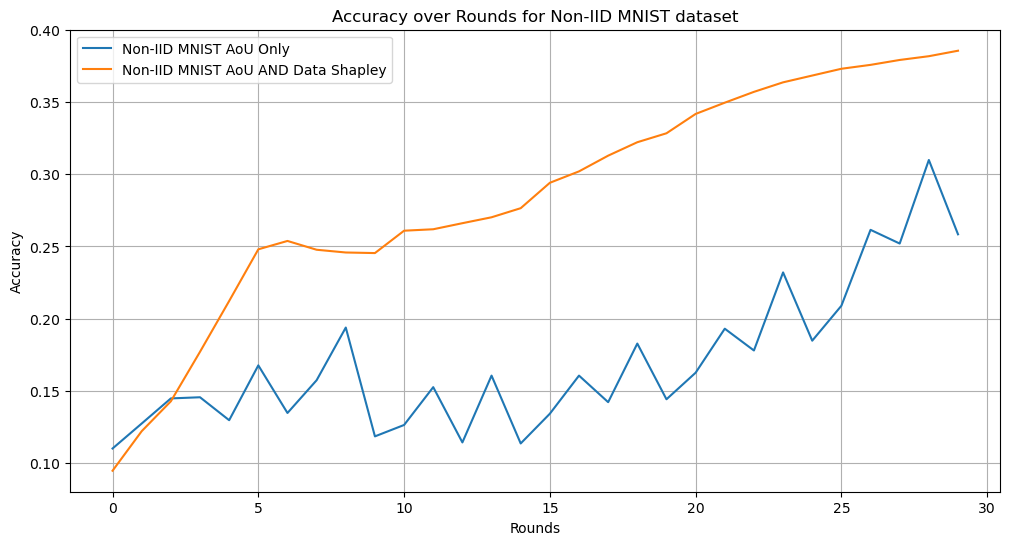

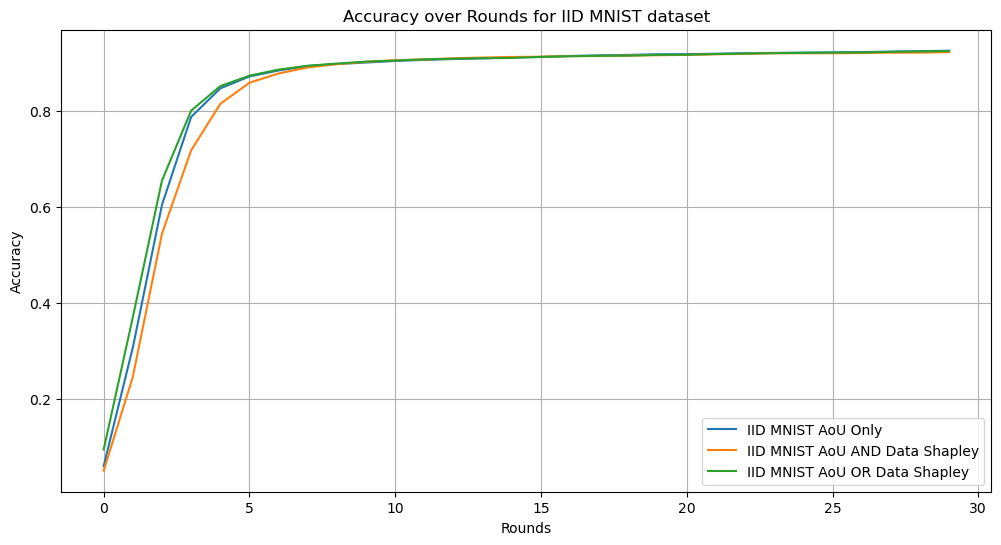

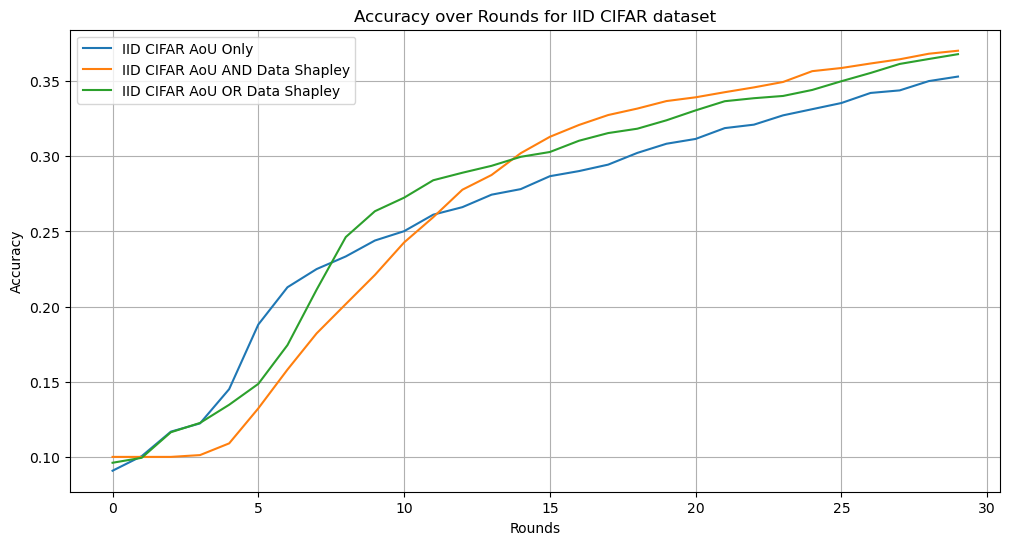

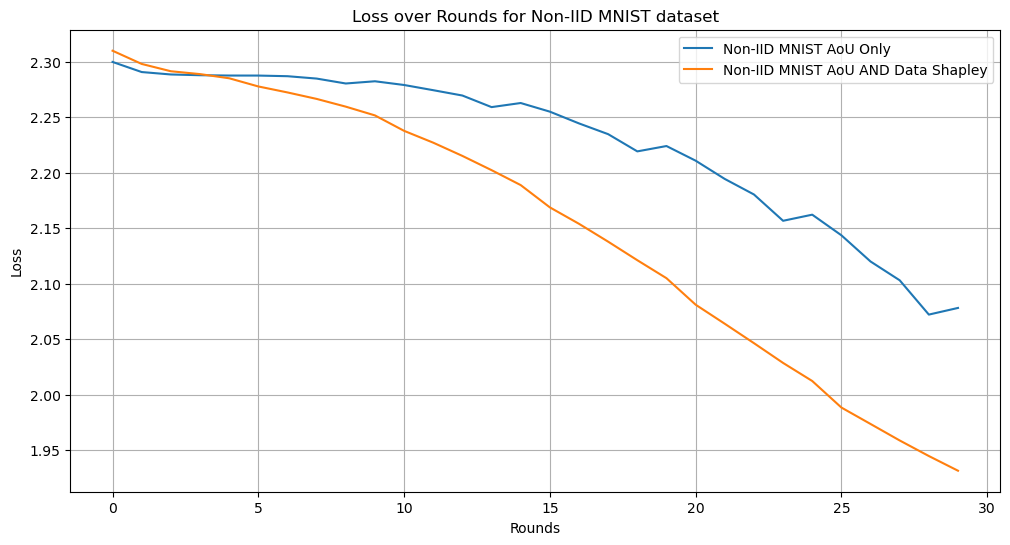

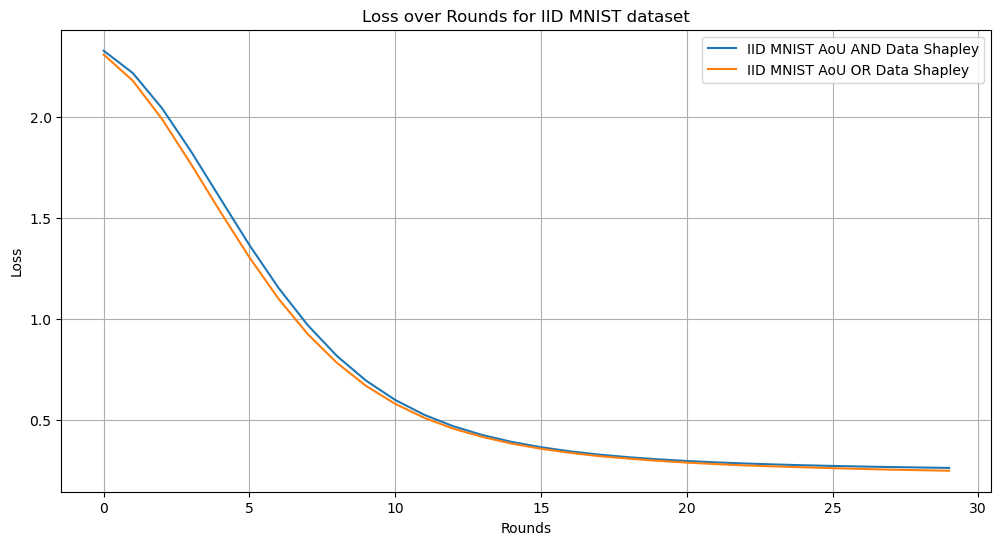

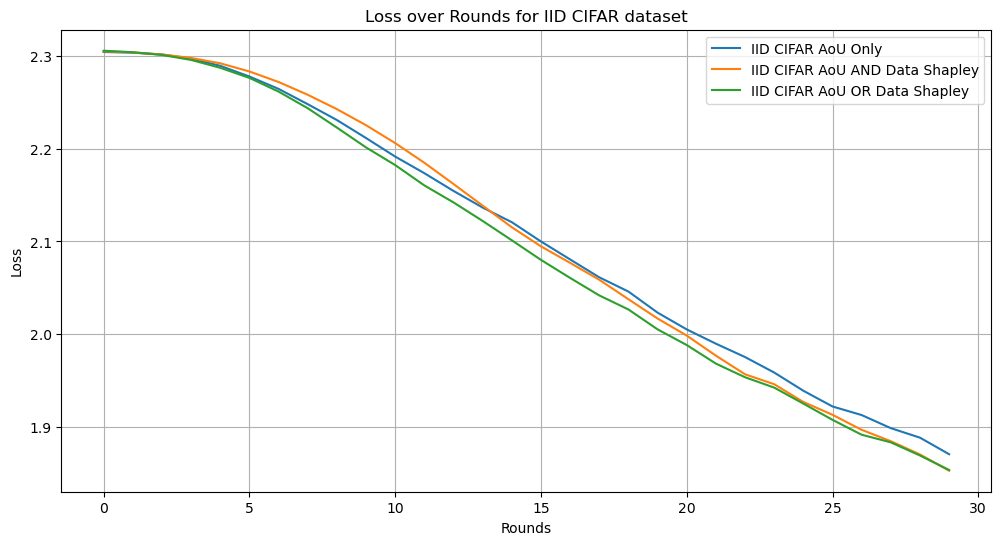

In [1]:
import matplotlib.pyplot as plt
#%%capture
%store -r -r iid_cifar_accuracies_and
%store -r iid_cifar_losses_and
%store -r iid_cifar_accuracies_or
%store -r iid_cifar_losses_or
%store -r iid_cifar_accuracies_only
%store -r iid_cifar_losses_only

%store -r iid_MNIST_accuracies_and
%store -r iid_MNIST_losses_and
%store -r iid_MNIST_accuracies_or
%store -r iid_MNIST_losses_or
%store -r iid_MNIST_accuracies_only
%store -r iid_MNIST_losses_only

%store -r non_IID_MNIST_accuracies_and
%store -r non_IID_MNIST_losses_and
# %store -r non_IID_MNIST_accuracies_or
# %store -r non_IID_MNIST_losses_or
%store -r non_IID_MNIST_accuracies_only
%store -r non_IID_MNIST_losses_only

rounds = 30

plt.figure(figsize=(12, 6))
plt.plot(range(rounds), non_IID_MNIST_accuracies_only, label='Non-IID MNIST AoU Only')
plt.plot(range(rounds), non_IID_MNIST_accuracies_and, label='Non-IID MNIST AoU AND Data Shapley')
# plt.plot(range(rounds), non_IID_MNIST_accuracies_or, label='Non-IID MNIST AoU OR Data Shapley')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds for Non-IID MNIST dataset')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(rounds), iid_MNIST_accuracies_only, label='IID MNIST AoU Only')
plt.plot(range(rounds), iid_MNIST_accuracies_and, label='IID MNIST AoU AND Data Shapley')
plt.plot(range(rounds), iid_MNIST_accuracies_or, label='IID MNIST AoU OR Data Shapley')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds for IID MNIST dataset')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(rounds), iid_cifar_accuracies_only, label='IID CIFAR AoU Only')
plt.plot(range(rounds), iid_cifar_accuracies_and, label='IID CIFAR AoU AND Data Shapley')
plt.plot(range(rounds), iid_cifar_accuracies_or, label='IID CIFAR AoU OR Data Shapley')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds for IID CIFAR dataset')
plt.legend()
plt.grid(True)
plt.show()

plt.figure (figsize=(12, 6))
plt.plot(range(rounds), non_IID_MNIST_losses_only, label='Non-IID MNIST AoU Only')
plt.plot(range(rounds), non_IID_MNIST_losses_and, label='Non-IID MNIST AoU AND Data Shapley')
# plt.plot(range(rounds), non_IID_MNIST_losses_or, label='Non-IID MNIST AoU OR Data Shapley')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss over Rounds for Non-IID MNIST dataset')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
#plt.plot(range(rounds), iid_MNIST_losses_only, label='IID MNIST AoU Only')
plt.plot(range(rounds), iid_MNIST_losses_and, label='IID MNIST AoU AND Data Shapley')
plt.plot(range(rounds), iid_MNIST_losses_or, label='IID MNIST AoU OR Data Shapley')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss over Rounds for IID MNIST dataset')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(rounds), iid_cifar_losses_only, label='IID CIFAR AoU Only')
plt.plot(range(rounds), iid_cifar_losses_and, label='IID CIFAR AoU AND Data Shapley')
plt.plot(range(rounds), iid_cifar_losses_or, label='IID CIFAR AoU OR Data Shapley')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss over Rounds for IID CIFAR dataset')
plt.legend()
plt.grid(True)
plt.show()
